```
         Copyright Rein Halbersma 2020-2021.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Chapter 2 Multi-armed Bandits

In [1]:
import gym
import mizani.formatters as mf
import numpy as np
import pandas as pd
import plotnine as p9

from doctrina.algorithms import bandit

In [2]:
# To be able to print Greek letters
alpha_chr = chr(945)
epsilon_chr = chr(949)

## 2.2 Action-value Methods

**Exercise 2.1**: *In $\varepsilon$-greedy action selection, for the case of two actions and $\varepsilon$ = 0.5, what is the probability that the greedy action is selected?*

**Answer**: the $k - 1$ non-greedy actions each have a probability of $\frac{\varepsilon}{k}$ of being selected, and for the greedy action the remaining probability is $1 - \varepsilon + \frac{\varepsilon}{k}$. Note that the greedy action is also being sampled in the exploration case, which is a common source of confusion, but actually simplifies the implementation because in the exploration case one can sample from all actions, instead of having to exclude the greedy action before sampling. Below a small function that verifies that for $k=2$ and $\varepsilon=0.5$ the probability equals 75%. 

In [3]:
def epsilon_greedy(k, epsilon):
    policy = np.full(k, epsilon / k)
    policy[0] += 1 - epsilon
    return policy

print(f'{epsilon_greedy(2, 0.5)[0]:.0%}')

75%


## 2.3 The 10-armed Testbed

In [4]:
k = 10
mu, sigma = 0, 1
s = 1
steps = 1_000
runs = 2_000
envs = np.array([
    gym.make('MultiArmedBandit-v0', k=k, mu=mu, sigma=sigma, s=s, steps=steps) 
    for _ in range(runs)
])

In [5]:
df = (pd
    .DataFrame(np.random.randn(steps, k) + envs[0].q_star)
    .rename_axis('steps')
    .reset_index()
    .melt(id_vars='steps', var_name='arm', value_name='reward')
)

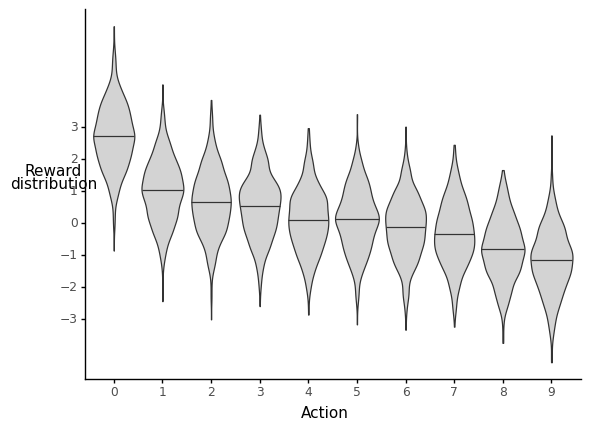

<ggplot: (8770955704742)>


In [6]:
fig_2_1 = (
    p9.ggplot(df, p9.aes(x='arm', y='reward')) +
    p9.geom_violin(fill='#d3d3d3', draw_quantiles=0.5) +
    p9.xlab('Action') + p9.ylab('Reward\ndistribution') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0)) +
    p9.scale_y_continuous(breaks=[-3, -2, -1, 0, 1, 2, 3])
)
print(fig_2_1)

**Figure 2.1**: *An example bandit problem from the 10-armed testbed. The true value $q_{\star}(a)$ of each of the ten actions was selected according to a normal distribution with mean zero and unit variance, and then the actual rewards were selected according to a mean $q_{\star}(a)$, unit-variance normal distribution, as suggested by these gray distributions.*
 
**NOTE**: *the 10 arms were sorted from high to low on their true values $q_{\star}(a)$ in this plot.*

In [7]:
scenarios = [
    {'epsilon': epsilon}
    for epsilon in [ 0, .01, .1 ]
]
descriptions = [ 
    f'{epsilon_chr}={params["epsilon"]}' 
    for params in scenarios
]
descriptions[0] += ' (greedy)'

In [8]:
*_, a_hist, r_hist = tuple(
    list(t)
    for t in zip(*[
        bandit.Q_control_eps(envs, steps, **params)
        for params in scenarios
    ])
)

100%|██████████| 2000/2000 [00:51<00:00, 38.51it/s]


In [ ]:
df_rh = pd.concat([
    bandit.reward_history(rh, descriptions[i], **scenarios[i])
    for i, rh in enumerate(r_hist)
])
df_ah = pd.concat([
    bandit.action_history(ah, descriptions[i], **scenarios[i])
    for i, ah in enumerate(a_hist)
])

In [ ]:
fig_2_2_upper = (
    p9.ggplot(df_rh, p9.aes(x='steps', y='reward')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('Average\nreward') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)
fig_2_2_lower = (
    p9.ggplot(df_ah.query('arm == 0'), p9.aes(x='steps', y='selected')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('%\nOptimal\naction') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0)) +
    p9.scale_y_continuous(breaks=[.0, .2, .4, .6, .8, 1.], labels=mf.percent_format(), limits=(0,1))

)
print(fig_2_2_upper)
print(fig_2_2_lower)

**Figure 2.2**: *Average performance of $\varepsilon$-greedy action-value methods on the 10-armed testbed. These data are averages over 2000 runs with different bandit problems. All methods used sample averages as their action-value estimates.*

In [ ]:
(
    p9.ggplot(df_ah, p9.aes(x='steps', y='selected')) +
    p9.geom_line(p9.aes(color='arm')) +
    p9.facet_grid('. ~ description') +
    p9.xlab('Steps') + p9.ylab('%\nSelected\naction') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0)) +
    p9.scale_y_continuous(breaks=[.0, .2, .4, .6, .8, 1.], labels=mf.percent_format(), limits=(0,1))
)

**Bonus figure**: *evolution of all action probabilities for the three $\varepsilon$-greedy action-value methods on the 10-armed testbed.*

**Exercise 2.2: Bandit example** *Consider a k-armed bandit problem with k = 4 actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit  algorithm using $\varepsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of Q1(a) = 0, for all a. Suppose the initial sequence of actions and rewards is A1 = 1, R1 = −1, A2 = 2, R2 = 1, A3 = 2, R3 = −2, A4 = 2, R4 = 2, A5 = 3, R5 = 0. On some of these time steps the $\varepsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?*

**Answer**: Exploration could have occurred on any time step, since any action can be selected at any time with an $\varepsilon$-greedy strategy. Exploration had to have occured on time steps where one of the best actions so far wasn't selected. This happened on time steps 4 and 5. On time step 4, action 2 had a Q-value of -0.5 at that point (the average of its rewards of +1 and -2 on times steps 2 and 3), whereas all previously non-selected actions still their initial Q-values of zero. On time step 5, the selected action 3 still had its initial Q-value of zero, whereas action 2 had a Q-value of +0.33 (the average of its rewards of +1, -2 and +2).

**Exercise 2.3**: *In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.*

**Answer**: for the $\varepsilon$-greedy strategies, we can use the answer from exercise 2.1 to find that the asymptotic probability of selecting the best action is $1 - \varepsilon + \frac{\varepsilon}{k}$, which for $k=10$ yields 99.1% and 91% for $\varepsilon=0.01$ and $\varepsilon=0.1$, respectively. For the greedy strategy with $\varepsilon=0$, the asymptotic probability is much harder to compute theoretically. But figure 2.3 showed that the probability stays virtually constant after the initial steps, so we rely on the actual sample average after 1000 steps and find approximately 36-37%, depending on the random seed.

In [ ]:
print(f'{np.bincount(a_hist[0][:, -1], minlength=k)[0] / runs:.1%}')
print(f'{epsilon_greedy(k, .01)[0]:.1%}')
print(f'{epsilon_greedy(k, .1)[0]:.1%}')

For the cumulative reward, we could rely on the sample averages, but it's instructive to realize that the $k$ sorted values for $q_{\star}(a)$ correspond to the [order statistics](https://en.wikipedia.org/wiki/Order_statistic) for the normal distribution. An approximate formula for this can be found in various sources, we use one from [StackOverflow](https://stats.stackexchange.com/a/9007/84431), adapted to our 0-based indexing of actions. The computation below demonstrates that the sample average values indeed quite closely match these order statistics.

In [ ]:
from scipy.stats import norm

# https://stats.stackexchange.com/a/9007/84431
def normal_order_statistic(r, n):
    a = 3 / 8
    return norm.ppf((r + 1 - a) / (n + 1 - 2 * a))

order_statistics = np.array([
    normal_order_statistic(r, k) 
    for r in reversed(range(k))
])

values = np.vstack([env.q_star for env in envs])
print(values.mean(axis=0))
print(order_statistics)

The asympototic average reward is then given by the inner product between the $k$ order statistics and the asymptotic action selection probabilities for all $k$ actions.

In [ ]:
print(order_statistics @ np.bincount(a_hist[0][:, -1], minlength=k) / runs)
print(order_statistics @ epsilon_greedy(k, .01))
print(order_statistics @ epsilon_greedy(k, .1))

In [ ]:
df = (pd
    .DataFrame(values)
    .rename_axis('env')
    .reset_index()
    .melt(id_vars='env', var_name='arm')
)

In [ ]:
(
    p9.ggplot(df, p9.aes(x='arm', y='value')) + 
    p9.geom_violin(fill='#d3d3d3', draw_quantiles=0.5) +
    p9.xlab('Action') + p9.ylab('Value\ndistribution') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0)) +
    p9.scale_y_continuous(breaks=[-3, -2, -1, 0, 1, 2, 3])
)

**Bonus figure**: *The sampling distribution for the true value $q_{\star}(a)$ of each of the ten actions for 2000 different bandits, selected from  a normal distribution with mean zero and unit variance, and sorted from high to low.*

## 2.5 Tracking a Nonstationary Problem

**Bonus**: proof that the coefficients for $Q_{1}$ and $R_{i}$ in (2.6) sum to 1:
\begin{eqnarray}
    & & (1 - \alpha)^{n} + \sum_{i = 1}^{n} \alpha (1 - \alpha)^{n - i} \\
    &=& (1 - \alpha)^{n} - \alpha (1 - \alpha)^{n} + \sum_{i = 0}^{n} \alpha (1 - \alpha)^{n - i} \\
    &=& (1 - \alpha)^{n + 1} + \alpha (1 - \alpha)^{n} \sum_{i = 0}^{n} \frac{1}{(1 - \alpha)^{i}} \\
    &=& (1 - \alpha)^{n + 1} + \alpha (1 - \alpha)^{n} \frac{1 - \frac{1}{(1 - \alpha)^{n + 1}}}{1 - \frac{1}{(1 - \alpha)}} \\
    &=& (1 - \alpha)^{n + 1} + \alpha (1 - \alpha)^{n} \frac{1 - \frac{1}{(1 - \alpha)^{n + 1}}}{- \frac{\alpha}{(1 - \alpha)}} \\
    &=& (1 - \alpha)^{n + 1} - (1 - \alpha)^{n + 1} \left(1 - \frac{1}{(1 - \alpha)^{n + 1}}\right) \\
    &=& 1
\end{eqnarray}
where in the third equality we used the geometric sum 
\begin{equation}
    \sum_{i = 0}^{n} x^{i} = \frac{1 - x^{n + 1}}{1 - x} \text{ for } x = \frac{1}{1 - \alpha}
\end{equation}

**Exercise 2.4** *If the step-size parameters, $\alpha_{n}$, are not constant, then the estimate $Q_{n}$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?*

**Answer**:

\begin{eqnarray}
Q_{n + 1} 
    &=& Q_{n} + \alpha_{n} (R_{n} - Q_{n}) \\
    &=& \alpha_{n} R_{n} + (1 - \alpha_{n}) Q_{n} \\
    &=& \alpha_{n} R_{n} + (1 - \alpha_{n}) (Q_{n - 1} + \alpha_{n - 1} (R_{n - 1} - Q_{n - 1})) \\
    &=& \alpha_{n} R_{n} + (1 - \alpha_{n}) \alpha_{n - 1} R_{n - 1} + (1 - \alpha_{n})(1 - \alpha_{n - 1}) Q_{n - 1} \\
    &=& \dots \\
    &=& \prod_{i = 1}^{n} (1 - \alpha_{i}) Q_{1} + \sum_{i = 1}^{n} \alpha_{i} \prod_{j = i + 1}^{n} (1 - \alpha_{j}) R_{i}
\end{eqnarray}

**Exercise 2.5 (programming)** *Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_{\star}(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_{\star}(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\varepsilon = 0.1$ and longer runs, say of 10,000 steps.*

**Answer**: TODO

## 2.6 Optimistic Initial Values

In [ ]:
scenarios = [
    {'epsilon': 0.0, 'Q0': 5},
    {'epsilon': 0.1, 'Q0': 0}
]
descriptions = [
    f'Q1={params["Q0"]}, {epsilon_chr}={params["epsilon"]}'
    for params in scenarios
]

In [ ]:
*_, a_hist, r_hist = tuple(
    list(t)
    for t in zip(*[
        bandit.Q_control_eps(envs, steps, alpha=0.1, **params)
        for params in scenarios
    ])
)

In [ ]:
df_rh = pd.concat([
    bandit.reward_history(rh, descriptions[i], **scenarios[i])
    for i, rh in enumerate(r_hist)
])
df_ah = pd.concat([
    bandit.action_history(ah, descriptions[i], **scenarios[i])
    for i, ah in enumerate(a_hist)
])

In [ ]:
fig_2_3_upper = (
    p9.ggplot(df_rh, p9.aes(x='steps', y='reward')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('Average\nreward') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)
fig_2_3_lower = (
    p9.ggplot(df_ah.query('arm == 0'), p9.aes(x='steps', y='selected')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('%\nOptimal\naction') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0)) +
    p9.scale_y_continuous(breaks=[.0, .2, .4, .6, .8, 1.], labels=mf.percent_format(), limits=(0,1))
)
print(fig_2_3_upper)
print(fig_2_3_lower)

**Figure 2.3**: *The effect of optimistic initial action-value estimates on the 10-armed testbed. Both methods used a constant step-size parameter, $\alpha$ = 0.1.*

**Exercise 2.6: Mysterious Spikes** *The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?*

**Answer**: in the first step, the $\varepsilon$-greedy algorithm with optimistic initial values $Q_{1} = 5$ selects randomly among the as-yet-untried actions. The updated $Q_{2}(a)$ for that action, will be equal to $0.9 Q_{1} + 0.1 R_{1}$. From figure 2.1 we deduce that it is unlikely that any tried action will have its first return above 5. For the first 10 steps, the algorithm therefore selects randomly among the as-yet-untried actions, although it might occasionally explore the same action more than once in the first 10 steps (as exercise 2.2 showed, any action can be explored at any time with $\varepsilon$-greedy selection).

At $t = 11$, all actions will differ in the $Q_{t}(a)$ that they obtained in their first try. On average, the best arm will have the best $Q_{10}(a)$, and so it will be the most frequently selected by the $\varepsilon$-greedy selection at $t = 11$. This explains the upward spike.  

At subsequent steps, the previously selected arm will have its $Q_{1}$ dependence further diluted by $1 - \alpha = 0.9$ (see exercise 2.4) and the best arm will eventually overcome the initial bias inside the $Q$-values for inferior arms.

In order to have sufficient exploration, the initial optimistic values need to be sufficiently large compared to the first-order statistic (see exercise 2.3) among the $k$ bandits' $q_{\star}(a)$-values and their sampling standard deviation for the rewards. For $k = 10$, the first-order statistic for a standard normal distribution is around 1.55, so an initial bias $Q_{1} = 5$ is 3.45 standard deviations above that, which seems sufficiently robust. 

**Exercise 2.7: Unbiased Constant-Step-Size Trick** *In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on  nonstationary problems? One way is to use a step size of*
\begin{equation}
    \beta_{n} \doteq \alpha / o_{n}
\end{equation}
*to process the $n$th reward for a particular action, where $\alpha \gt 0$ is a conventional constant step size, and $o_{n}$ is a trace of one that starts at 0:*
\begin{equation}
    o_{n} \doteq o_{n - 1} + \alpha (1 - o_{n - 1}) \text{ for } n \geq 0 \text{ with } o_{0} \doteq 0
\end{equation}
*Carry out an analysis like that in (2.6) to show that $Q_{n}$ is an exponential recency-weighted average without initial bias.*

**Answer**: substitute $\beta_{n}$ for $\alpha$ in the RHS of (2.6)
\begin{eqnarray}
Q_{n + 1} 
    &=& Q_{n} + \beta_{n} (R_{n} - Q_{n}) \\
    &=& Q_{n} + \frac{\alpha}{o_{n}} (R_{n} - Q_{n})
\end{eqnarray}
Multiply both sides of the last equation with $o_{n}$
\begin{equation}
    o_{n} Q_{n + 1} = o_{n} Q_{n} + \alpha (R_{n} - Q_{n})
\end{equation}
Substitute the recurrence relation (2.9) in the RHS of the last equation:
\begin{eqnarray}
o_{n} Q_{n + 1} 
    &=& (o_{n - 1} + \alpha (1 - o_{n - 1}) Q_{n} + \alpha(R_{n} - Q_{n}) \\
    &=& o_{n - 1} Q_{n} + \alpha (R_{n} - o_{n - 1} Q_{n})
\end{eqnarray}
So we see that $o_{n} Q_{n + 1}$ is subject to the same update equation as $Q_{n + 1}$ in the case of constant $\alpha$. This implies that we can use the solution (2.6)
\begin{eqnarray}
o_{n} Q_{n + 1} 
    &=& (1 - \alpha)^{n} o_{0} Q_{1} + \sum_{i = 1}^{n} \alpha (1 - \alpha)^{n - i} R_{i} \\
    &=& \sum_{i = 1}^{n} \alpha (1 - \alpha)^{n - i} R_{i}
\end{eqnarray}
where the last equality follows because $o_{0} \doteq 0$ by definition. So $Q_{n + 1}$ does not depend on $Q_{1}$ and is hence without initial bias. As an extra check: $o_{1} \doteq \alpha$ so $\beta_{n} \doteq 1$ and therefore $Q_{2}$ indeed does not depend on $Q_{1}$ but equals $R_{1}$, just as in the case of a step-size parameter $\frac{1}{n}$.


**Bonus**: the recurrence relation (2.9) has a fixed point $o_{n} = 1$ when $n$ goes to infinity, so that $\beta_{n}$ asymptotically approaches $\alpha$.

## 2.7 Upper-Confidence-Bound Action Selection

In [ ]:
descriptions = [
    f'{epsilon_chr}-greedy {epsilon_chr}=0.1',
    f'UCB c=2'
]

In [ ]:
*_, a_hist, r_hist = tuple(
    list(t)
    for t in zip(*[
        bandit.Q_control_eps(envs, steps, epsilon=.1),
        bandit.Q_control_ucb(envs, steps, c=2)
    ])
)

In [ ]:
df_rh = pd.concat([
    bandit.reward_history(rh, descriptions[i])
    for i, rh in enumerate(r_hist)
])
df_ah = pd.concat([
    bandit.action_history(ah, descriptions[i])
    for i, ah in enumerate(a_hist)
])

In [ ]:
fig_2_4_upper = (
    p9.ggplot(df_rh, p9.aes(x='steps', y='reward')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('Average\nreward') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)
fig_2_4_lower = (
    p9.ggplot(df_ah.query('arm == 0'), p9.aes(x='steps', y='selected')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('%\nOptimal\naction') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0)) +
    p9.scale_y_continuous(breaks=[.0, .2, .4, .6, .8, 1.], labels=mf.percent_format(), limits=(0,1))
)
print(fig_2_4_upper)
print(fig_2_4_lower)

**Figure 2.4** *Average performance of UCB action selection on the 10-armed testbed. As shown, UCB generally performs better than $\varepsilon$-greedy action selection, except in the first k steps, when it selects randomly among the as-yet-untried actions.*

**Exercise 2.8: UCB Spikes** *In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If c = 1, then the spike is less prominent.*

**Answer**: in the first 10 steps, the UCB algorithm selects randomly among the as-yet-untried actions. 

At $t = 11$, all actions will have the same exploration term $c \sqrt\frac{\log t}{N_{t}(a)}$ with $N_{10}(\cdot) \doteq 1$ and only differ in their exploitation term $Q_{t}(a)$ that they obtained in their first try. On average, the best arm will have the best $Q_{10}(a)$, and so it will be the most frequently selected by the UCB formula (2.10) at $t = 11$. This explains the upward spike. Note that the spike's increase is independent of $c$. 

At $t = 12$, the arm selected in the previous step will have $N_{11}(a) = 2$ whereas the other arms still have $N_{11}(a) = 1$. This corresponds to exploration terms of approximately $1.11 c$ for the previously select arm, and $1.58 c$ for the remaining arms. For $c = 2$, this corresponds to exploration terms of $2.23$ and $3.15$ respectively. The exploitation term $Q_{11}(a)$ for the previously selected action therefore has to be approximately 0.92 higher than the second best arm in order for it to be selected again. In the answer to exercise 2.3, we showed that the best action had a mean reward that was on average 0.55 higher than the second best arm. This explains why for $c = 2$ the spike will substantially decrease at $t = 12$, whereas for $c = 1$ the spike's decrease is less prominent since it's more likely the higher exploitation term will compensate for the lower exploration term in the UCB selection formula (2.10).

## 2.8 Gradient Bandit Algorithms

In [ ]:
envs4 = np.array([
    gym.make('Bandit-v0', k=k, mu=4, sigma=sigma, s=s, steps=steps) 
    for _ in range(runs)
])

In [ ]:
scenarios = [
    {'alpha': alpha, 'baseline': baseline}
    for alpha in [ 0.1, 0.4 ]
    for baseline in [ False, True ]
]
descriptions = [
    f'{alpha_chr}={params["alpha"]} with{"out" if not params["baseline"] else ""} baseline'
    for params in scenarios
]

In [ ]:
*_, a_hist, r_hist = tuple(
    list(t)
    for t in zip(*[
        bandit.Q_control_grad(envs4, steps, **params)
        for params in scenarios
    ])
)

In [ ]:
df_rh = pd.concat([
    bandit.reward_history(rh, descriptions[i], **scenarios[i])
    for i, rh in enumerate(r_hist)
])
df_ah = pd.concat([
    bandit.action_history(ah, descriptions[i], **scenarios[i])
    for i, ah in enumerate(a_hist)
])

In [ ]:
fig_2_5_upper = (
    p9.ggplot(df_rh, p9.aes(x='steps', y='reward')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('Average\nreward') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)
fig_2_5_lower = (
    p9.ggplot(df_ah.query('arm == 0'), p9.aes(x='steps', y='selected')) +
    p9.geom_line(p9.aes(color='description')) +
    p9.xlab('Steps') + p9.ylab('%\nOptimal\naction') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0)) +
    p9.scale_y_continuous(breaks=[.0, .2, .4, .6, .8, 1.], labels=mf.percent_format(), limits=(0,1))
)
print(fig_2_5_upper)
print(fig_2_5_lower)

**Figure 2.5**: *Average performance of the gradient bandit algorithm with and without a reward baseline on the 10-armed testbed when the $q_{\star}(a)$ are chosen to be near +4 rather than near zero.*

## 2.9 Associative Search (Contextual Bandits)

**Exercise 2.10** *Suppose you face a 2-armed bandit task whose true action values change
randomly from time step to time step. Specifically, suppose that, for any time step,
the true values of actions 1 and 2 are respectively 10 and 20 with probability 0.5 (case
A), and 90 and 80 with probability 0.5 (case B). If you are not able to tell which case
you face at any step, what is the best expected reward you can achieve and how should
you behave to achieve it? Now suppose that on each step you are told whether you are
facing case A or case B (although you still don’t know the true action values). This is an
associative search task. What is the best expected reward you can achieve in this task,
and how should you behave to achieve it?*

**Answer**: without any context, the expected rewards for both two actions are $Q(1) = (10 + 90) 0.5 = 50$ and $Q(2) = (20 + 80) 0.5 = 20$. All the algorithms discussed in this chapter will eventually converge on these two values $Q(1)$ and $Q(2)$ and the best reward we can achieve is 50.

When it is known whether we are in case A or case B, we can treat the problem as a contextual bandit and keep track of the state to learn four $Q$-values: $Q_{A}(1) = 10$, $Q_{A}(2) = 20$, $Q_{B}(1) = 90$ and $Q_{B}(2) = 80$. The best expected reward we can achieve then is to select action 2 in case A and action 1 in case B, for a total expected reward of $55 = (20 + 90) 0.5$.

## 2.10 Summary

In [ ]:
scenarios = [
    {'epsilon': 2**exponent }
    for exponent in range(-7, -1)
]

In [ ]:
*_, a_hist, r_hist = tuple(
    list(t)
    for t in zip(*[
        bandit.Q_control_eps(envs, steps, **params)
        for params in scenarios
    ])
)

TODO

**Figure 2.6**: *A parameter study of the various bandit algorithms presented in this chapter. Each point is the average reward obtained over 1000 steps with a  particular algorithm at a particular setting of its parameter.*

**Exercise 2.11 (programming)** *Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size $\varepsilon$-greedy algorithm with $\alpha=0.1$. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.*

**Answer**: TODO